In [1]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import sent_tokenize
import spacy

import statsmodels.tsa.stattools as tsatools
from statsmodels.stats.multitest import multipletests

import ruptures as rpt

import pandas as pd
import swifter

import numpy as np
import math
import random

import os
import sys
import re

import heapq
import itertools
import collections

import pickle

from matplotlib import pyplot as plt
import seaborn as sns



import nb_trending


/n/fs/policyphylog/PrivacyPolicyPlagiarism/.venv/lib64/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: thinc.extra.search.Beam size changed, may indicate binary incompatibility. Expected 112 from C header, got 120 from PyObject
  return f(*args, **kwds)


In [2]:
from tqdm import tqdm
tqdm.pandas()

# Load data

In [3]:
#Load the data
with open("../data/deduped_policy_text_v11no_html_with_links_and_emails.pickle", "rb") as f:
    df_all = pd.read_pickle(f)
df_sample = df_all.sample(1000)

In [4]:
policy_counts = df_all.groupby("year_season").size()

In [5]:
ys_values = sorted(list(policy_counts.index))

In [6]:
print(list(df_all))

['site_url', 'year', 'season', 'policy_text', 'policy_snapshot_url', 'policy_filetype', 'raw_source_path', 'link_text', 'homepage_snapshot_url', 'homepage_snapshot_redirected_url', 'sha1', 'flesch_kincaid', 'smog', 'flesch_ease', 'policy_title', 'text_len', 'word_count', 'year_season', 'simhash', 'policy_url', 'home_domain', 'ip_based_homepage_url', 'categories', 'policy_snapshot_domain', 'strict_updated', 'simhash_updated', 'homepage_snapshot_domain', 'homepage_snapshot_redirected_domain', 'parked_domain', 'classifier_probability', 'alexa_rank', 'cross_domain_homepage_redir', 'redirected_to_similar_domain', 'cross_domain_policy', 'emails', 'has_email', 'links', 'has_external_link']


# Readability

In [7]:
df_all.categories

237698                            education
1043500    education;entertainment;shopping
892937                        uncategorized
1118180                            shopping
337273                   business;education
                         ...               
1221991                  business;education
340360             business;informationtech
892528                             shopping
79317                          newsandmedia
547901                   business;education
Name: categories, Length: 910546, dtype: object

In [8]:
categories = set(itertools.chain.from_iterable(map(lambda s: s.split(";"), df_all.categories)))

In [9]:
categories = sorted(list(categories))
for category in categories:
    df_all[category] = False
    
def break_categories(row):
    for category in row.categories.split(';'):
        row[category] = True
        
    return row
    
df = df_all.progress_apply(break_categories,axis=1)

100%|██████████| 910546/910546 [01:15<00:00, 11994.05it/s]


In [10]:
df = df[df.year >= 2009]

In [11]:
categories_ct = pd.DataFrame([
    (category, len(df[df[category]])) for category in categories
],columns=["category","count"]).sort_values("count",ascending=False)

top_categories = list(categories_ct.category.iloc[:8])

#top_categories = 

In [12]:
#Forcibly add "health"
top_categories.append("health")

In [13]:
in_top_cat = len(df[df[top_categories].any(axis=1)])
all_items = len(df)

in_top_cat/all_items,in_top_cat,all_items

(0.903675780294683, 687287, 760546)

In [14]:
categories_ct

,category,count
5,business,418843
11,education,210873
32,shopping,110365
20,informationtech,108553
12,entertainment,106815
38,uncategorized,27745
25,newsandmedia,26107
1,adult,22872
15,games,19471
26,parked,17775


In [15]:
plot_data = pd.DataFrame()

for category in top_categories:
    fk_data = df[df[category]].groupby("year_season").flesch_kincaid.mean() 
    fk_data = fk_data.reset_index()
    fk_data["category"] = category
    plot_data = plot_data.append(fk_data)
    
all_fk_data = df.groupby("year_season").flesch_kincaid.mean().reset_index()
all_fk_data["category"] = "all"
#plot_data = plot_data.append(fk_data)


In [16]:
plot_data = pd.DataFrame()

df["ever_1k"] = df.site_url.isin(set(df[df.alexa_rank <= 1000].site_url.unique()))
df["ever_10k"] = df.site_url.isin(set(df[df.alexa_rank <= 10000].site_url.unique()))

df["top_1k"] = df.alexa_rank <= 1000
df["top_10k"] = df.alexa_rank <= 10000

for category in top_categories:
    fk_data = df[df[category]][["year_season","flesch_kincaid","word_count","top_1k","top_10k","ever_1k","ever_10k"]]
    fk_data = fk_data[fk_data.flesch_kincaid.notnull()]
    fk_data["category"] = category
    plot_data = plot_data.append(fk_data)
    
all_fk_data = df[["year_season","flesch_kincaid","word_count","top_1k"]]
all_fk_data = all_fk_data[all_fk_data.flesch_kincaid.notnull()]
all_fk_data["category"] = "all"

In [17]:
plot_data = plot_data.sort_values("year_season")
all_fk_data = all_fk_data.sort_values("year_season")

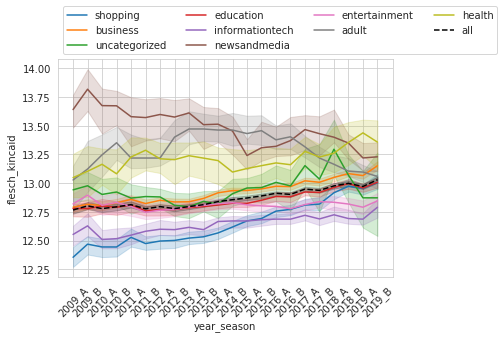

In [28]:
estimator = np.median
sns.lineplot(x="year_season",y="flesch_kincaid",hue="category",data=plot_data,estimator=estimator,ci=95)
ax = sns.lineplot(x="year_season",y="flesch_kincaid",color="black",dashes=[(2,2)],data=all_fk_data,label="all",estimator=estimator,ci=95)
ax.lines[-1].set_linestyle("--")
plt.legend(bbox_to_anchor=(0,1),loc="lower left",ncol=4)
plt.setp(ax.get_xticklabels(),rotation=45)
pass

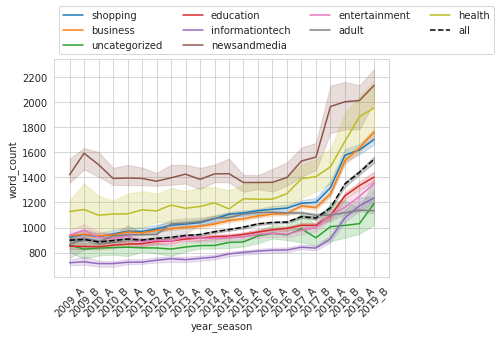

In [29]:
estimator = np.median
sns.lineplot(x="year_season",y="word_count",hue="category",data=plot_data,estimator=estimator,ci=95)
ax = sns.lineplot(x="year_season",y="word_count",color="black",dashes=[(2,2)],data=all_fk_data,label="all",estimator=estimator,ci=95)
ax.lines[-1].set_linestyle("--")
plt.legend(bbox_to_anchor=(0,1),loc="lower left",ncol=4)
plt.setp(ax.get_xticklabels(),rotation=45)
pass

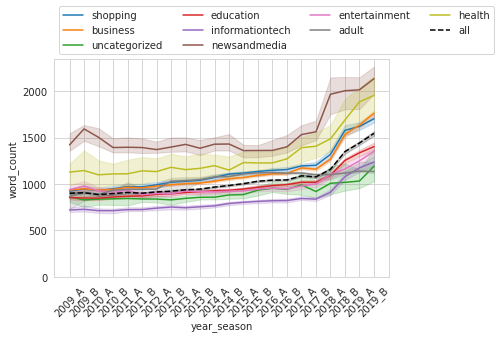

In [30]:
estimator = np.median
sns.lineplot(x="year_season",y="word_count",hue="category",data=plot_data,estimator=estimator,ci=95)
ax = sns.lineplot(x="year_season",y="word_count",color="black",dashes=[(2,2)],data=all_fk_data,label="all",estimator=estimator,ci=95)
ax.lines[-1].set_linestyle("--")
plt.legend(bbox_to_anchor=(0,1),loc="lower left",ncol=4)
plt.ylim(bottom=0)
plt.setp(ax.get_xticklabels(),rotation=45)
pass

In [38]:
print("Median\nHealth,All")
h1 = plot_data[(plot_data.category == "health") & (plot_data.year_season == "2015_B")].word_count.median()
h2 = plot_data[(plot_data.category == "health") & (plot_data.year_season == "2019_B")].word_count.median()
a1 = all_fk_data[all_fk_data.year_season == "2015_B"].word_count.median()
a2 = all_fk_data[all_fk_data.year_season == "2019_B"].word_count.median()


a1_std = all_fk_data[all_fk_data.year_season == "2015_B"].word_count.mean()
a2_std = all_fk_data[all_fk_data.year_season == "2019_B"].word_count.mean()

print(h1,a1)
print(h2,a2)
print(h2/h1,a2/a1)
print(a1_std,a2_std)




Median
Health,All
1226.0 1029.0
1953.5 1544.5
1.5933931484502446 1.500971817298348
1342.762104272096 2064.775933786078


In [40]:
print("Median\nHealth,All")
h1 = plot_data[(plot_data.category == "health") & (plot_data.year_season == "2015_B")].flesch_kincaid.median()
h2 = plot_data[(plot_data.category == "health") & (plot_data.year_season == "2019_B")].flesch_kincaid.median()
a1 = all_fk_data[all_fk_data.year_season == "2015_B"].flesch_kincaid.median()
a2 = all_fk_data[all_fk_data.year_season == "2019_B"].flesch_kincaid.median()



print(h1,a1)
print(h2,a2)
print(h2-h1,a2-a1)




Median
Health,All
13.1521452273217 12.888493750000002
13.35727796776009 13.029822889006905
0.20513274043839047 0.1413291390069027
